In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
from IPython.display import display
import os
import random
import shutil
import sys
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.datasets.utils import download_url
import tarfile
import matplotlib.pyplot as plt

In [2]:
SCRIPT_PATH = "/content/drive/MyDrive/Video Processing/Hw2/CNN.ipynb"
VAL_PATH = "/content/drive/MyDrive/Video Processing/Hw2/data/val"
TRAIN_PATH = "/content/drive/MyDrive/Video Processing/Hw2/data/train"
TRAIN_FULL_PATH = "/content/drive/MyDrive/Video Processing/Hw2/data/train_full"
TEST_PATH = "/content/drive/MyDrive/Video Processing/Hw2/data/test"
LABEL_PATH = "/content/drive/MyDrive/Video Processing/Hw2/trainLabels.csv"

In [3]:
labels = pd.read_csv(LABEL_PATH)
labels["png"] = labels["id"].apply(lambda x: str(x)+".png")

In [4]:
label_nonint = labels['label']
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(label_nonint)
labels['intlabel'] = integer_labels

In [5]:
labels.head(1)

,id,label,png,intlabel
0,1,frog,1.png,6


## Datasetin Yüklenmesi ve Dataset objesinin Oluşturulması

In [6]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz" # Datasetin linki
download_url(dataset_url, '.')
# Collab ortamında dataseti custom olarak içeri almak oldukça sancılı olabiliyor.
# Custom bir dataset objesi oluşturularak implementasyonu yapılmış olsa da
# modeli sadece bu haliyle eğitebildim.

Using downloaded and verified file: ./cifar10.tgz


In [7]:
# indirilen zipin açılması
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [8]:
DATA_DIR = '/content/data/cifar10'

print(os.listdir(DATA_DIR))
classes = os.listdir(DATA_DIR + "/train")
print(classes) # sınıflar neler ve setlerin listesi

['train', 'test']
['cat', 'airplane', 'truck', 'horse', 'automobile', 'bird', 'deer', 'ship', 'frog', 'dog']


In [9]:
truck = os.listdir(DATA_DIR + "/train/truck")
print('Truck sayisi', len(truck))
print(truck[:5])

Truck sayisi 5000
['4735.png', '1593.png', '4580.png', '2550.png', '1412.png']


In [10]:
dataset = ImageFolder(DATA_DIR+'/train', transform=ToTensor())

In [11]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


torch.Size([3, 32, 32]) 0


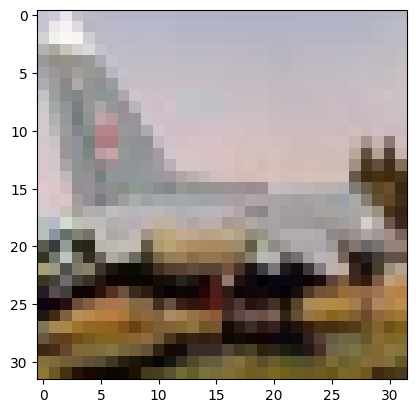

In [12]:
img, label = dataset[123] # 0. indexdeki veri
print(img.shape, label)
plt.imshow(img.permute(1, 2, 0)); # dünyanın en net plane'i

## Test - Train - Validation Datasets

In [13]:
set_len = dataset.__len__() # dataasette toplam 50k gözlem var. yüzde 20 si validation 80 i test olarak ayrılacak.

In [14]:
set_len

50000

In [15]:
# 80 - 20 ayrımını pytorch.utilsten random_split fonksiyonu ile yapıyoruz.
val_len = set_len * 0.2
train_len = set_len - val_len

train_dataset, val_dataset = random_split(dataset, [int(train_len), int(val_len)])
len(train_dataset), len(val_dataset)

(40000, 10000)

In [16]:
# datasetler hazırlandıktan sonra sıradaki adım bir validation ve train setleri için bir DataLoader objesi oluşturmak.
# Dataloader objesi pytorch utilslerinden birisi, forward propagation ve back propagation esnasında verinin batchler halinde
# beslenmesine olanak tanır.

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)

In [17]:
from torchvision.utils import make_grid

# bir batch içerisinde hangi görseller veriliyor. bunu görselleştirmek için aşağıdaki fonksiyonu kullanıyoruz.

def show_batch(dl):
    for images, intlabels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=32).permute(1, 2, 0))
        break

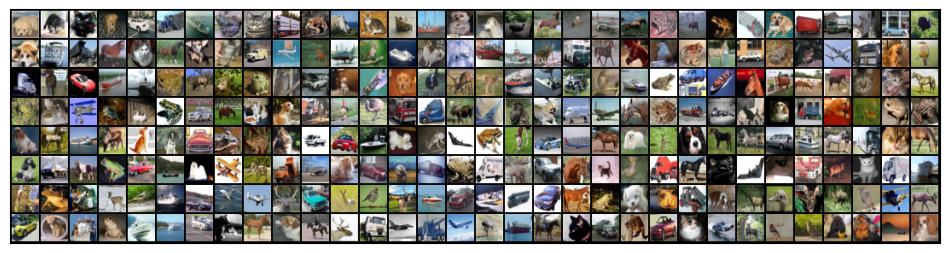

In [18]:
show_batch(train_loader) # İlk mini-batchin nasıl göründüğü

## Convolutional Neural Network Class'ının Tanımlanması

In [19]:
# bu simple model kullanılarak her bir convolution'dan çıkacak
# görsellerin sizelarını hesaplamaya gerek kalmadan görebiliriz.

simple_model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2)
)

In [20]:
for images, intlabel in train_loader:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([256, 3, 32, 32])
out.shape: torch.Size([256, 64, 16, 16])


In [21]:
tensor1 = torch.tensor([1, 2, 3, 4, 5])
tensor_float = tensor1.float()
tensor2 = torch.tensor([6, 7, 8, 9, 10])
tensor_float2 = tensor2.float()
a = torch.stack([tensor_float, tensor_float2]).mean() ## stack fonksiyonu nasıl çalışıyor.

In [22]:
a.item()

5.5

**OUTPUTLARIN DIMENSINLARINI HESAPLAMAK İCİN KULLACAGIMIZ FORMUL**
Formül olmadan giriş çıkış dimensionları karışabiliyor.

[(W−K+2P)/S]+1.

W is the input volume - in your case 128
K is the Kernel size - in your case 5
P is the padding - in your case 0 i believe
S is the stride - which you have not provided.

So, we input into the formula:

Output_Shape = (128-5+0)/1+1
Output_Shape = (124,124,40)

40 Filtre Count

In [23]:
import torch.nn as nn

class ThreeLayerCNN(nn.Module):
    def __init__(self):
        super(ThreeLayerCNN, self).__init__()
        # Conv layerları tanımlıyoruz.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        # activation function
        self.relu = nn.ReLU()
        # maxpool layer
        self.maxpool = nn.MaxPool2d(2)
        # Overfittingi engellemek için bir dropout
        self.dropout = nn.Dropout(p=0.5)  # dropout probability is 0.5 (you can adjust this value)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(2304, 1024) # buradaki input-output doğru mu kontrol edilecek.
        # Burada bir Relu daha olacak
        self.linear2 = nn.Linear(1024, 512)
        # Burada bir Relu Daha olacak.
        self.linear3 = nn.Linear(512, 10)

    def forward(self, x):
        # Apply convolutional layers
        x = self.conv1(x)
        #print("conv1:" , x.shape)
        x = self.relu(x)
        #print("relu:" , x.shape)
        x = self.conv2(x)
        #print("conv2:" , x.shape)
        x = self.relu(x)
        #print("relu:" , x.shape)
        x = self.maxpool(x)
        #print("maxpool:" , x.shape)
        x = self.conv3(x)
        #print("conv3:" , x.shape)
        x = self.relu(x)
        #print("relu:" , x.shape)
        x = self.maxpool(x)
        #print("maxpool:" , x.shape)
        x = self.flatten(x)
        #print("flatten:" , x.shape)
        x = self.linear1(x)
        #print("linear1:" , x.shape)
        x = self.relu(x)
        #print("relu:" , x.shape)
        x = self.dropout(x)  # Dropout overfittin için silver bullet değil, bir çok methodla birlikte çok daha etkili.
        #print("dropout:" , x.shape)
        x = self.linear2(x)
        #print("linear2:" , x.shape)
        x = self.relu(x)
        #print("relu:" , x.shape)
        x = self.linear3(x)

        return x

In [24]:
import torch.nn as nn

class FiveLayerCNN(nn.Module):
    def __init__(self):
        super(FiveLayerCNN, self).__init__()
        # Conv layerları tanımlıyoruz.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1)
        # activation function
        self.relu = nn.ReLU()
        # maxpool layer
        self.maxpool = nn.MaxPool2d(2)
        # Overfittingi engellemek için bir dropout
        self.dropout = nn.Dropout(p=0.5)  # dropout probability is 0.5 (you can adjust this value)
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1600, 1024) # buradaki input-output doğru mu kontrol edilecek.
        # Burada bir Relu daha olacak
        self.linear2 = nn.Linear(1024, 512)
        # Burada bir Relu Daha olacak.
        self.linear3 = nn.Linear(512, 10)

    def forward(self, x):
        # Apply convolutional layers
        x = self.conv1(x)
        #print("conv1:" , x.shape)
        x = self.relu(x)
        #print("relu:" , x.shape)
        x = self.conv2(x)
        #print("conv2:" , x.shape)
        x = self.relu(x)
        #print("relu:" , x.shape)
        x = self.conv3(x)
        #print("conv3:" , x.shape)
        x = self.relu(x)
        #print("relu:" , x.shape)
        x = self.maxpool(x)
        #print("maxpool:" , x.shape)
        x = self.conv4(x)
        #print("conv4:" , x.shape)
        x = self.relu(x)
        #print("relu:" , x.shape)
        x = self.conv5(x)
        #print("conv5:" , x.shape)
        x = self.relu(x)
        #print("relu:" , x.shape)
        x = self.maxpool(x)
        #print("maxpool:" , x.shape)
        x = self.flatten(x)
        #print("flatten:" , x.shape)
        x = self.linear1(x)
        #print("linear1:" , x.shape)
        x = self.relu(x)
        #print("relu:" , x.shape)
        x = self.dropout(x)  # Dropout overfittin için silver bullet değil, bir çok methodla birlikte çok daha etkili.
        #print("dropout:" , x.shape)
        x = self.linear2(x)
        #print("linear2:" , x.shape)
        x = self.relu(x)
        #print("relu:" , x.shape)
        x = self.linear3(x)

        return x

In [25]:
ThreeLayerCNNModel = ThreeLayerCNN()
FiveLayerCNNModel = FiveLayerCNN()

In [26]:
# bu obje aslında train süreci için önden oluşturulmuştur.
criterion = nn.CrossEntropyLoss()

In [27]:
for images, intlabel in train_loader:
    print('images.shape:', images.shape)
    out = ThreeLayerCNNModel(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

# sadece bir resim gönderildiğin sağlıklı bir şekilde çıktı alabildiğimizi görmüş olduk.

images.shape: torch.Size([256, 3, 32, 32])
out.shape: torch.Size([256, 10])
out[0]: tensor([-0.0259,  0.0543,  0.0279, -0.0213,  0.0341, -0.0204, -0.0209,  0.0425,
         0.0054, -0.0045], grad_fn=<SelectBackward0>)


In [28]:
def train_model(model, batch):
    # print("training_model ..") debug print
    images, intlabel = batch
    outputs = model(images)
    loss = criterion(outputs, intlabel)
    # print(type(loss))
    return outputs, loss

In [29]:
def validation_model(model, val_batch):
    images, intlabel = val_batch
    # print("validation model ..") # debug print
    outputs = model(images)
    loss = criterion(outputs, intlabel)
    # print(type(loss))
    acc = accuracy(outputs, intlabel)
    return (loss.detach(), acc) # loss detach ??

In [30]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [31]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  # print("evaluating ..") debug print
  outputs = [validation_model(model, val_batch) for val_batch in val_loader]
  batch_losses = [x[0] for x in outputs] # batch losslar
  batch_accs = [x[1] for x in outputs] # her batchin accucarsinin tutulduğu bir liste
  epoch_loss = torch.stack(batch_losses).mean()  # Combine losses # buraya bir .item() lazım
  epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
  return "epochloss, epoch_acc",[epoch_loss, epoch_acc]

In [32]:
# bu aşamada fit loop'unu buraya koyduğumuzda çalışıyor.
# ancak modeli ve tensörleri gpu'ya taşıyacağız ve modeli öyle çalıştıracağız.

## Move Models and Tensors Into GPU

In [33]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [34]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [35]:
device = get_default_device()
device # cuda çiğdemleri

device(type='cuda')

In [36]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
to_device(ThreeLayerCNNModel, device);
to_device(FiveLayerCNNModel, device); # hem modeli hem de dataloaderlarımızı gpu'ya taşıyoruz.

In [37]:
model = to_device(FiveLayerCNN(), device) # base model performansı
# ölçmek için

In [38]:
evaluate(model, val_loader) # initialize edilen modeli evaluate ediyoruz.


('epochloss, epoch_acc', [tensor(2.3030, device='cuda:0'), tensor(0.0995)])

In [39]:
# fit loop'u
history = []
optimizer = optim.Adam(ThreeLayerCNNModel.parameters(), lr= 0.001) # hyperparam

for i in range(20): # epoch_range
    ThreeLayerCNNModel.train()
    train_losses = []
    for batch in train_loader:
      outputs, loss = train_model(ThreeLayerCNNModel, batch) # training üzerinden loss hesaplanır
      train_losses.append(loss)
      # print(outputs, loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    _, result = evaluate(ThreeLayerCNNModel, val_loader)
    # print(result)
    # print(train_losses)

    result.append(torch.stack(train_losses).mean().item()) # listesnin bu halinde 0. index train_loss, 1.index validation_loss, 2.index epoch_loss
    history.append(result)
    print(" Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            i, result[2], result[0], result[1]))

 Epoch [0], train_loss: 1.6862, val_loss: 1.4062, val_acc: 0.4861
 Epoch [1], train_loss: 1.2916, val_loss: 1.1565, val_acc: 0.5821
 Epoch [2], train_loss: 1.1032, val_loss: 1.0865, val_acc: 0.6104
 Epoch [3], train_loss: 0.9673, val_loss: 0.9339, val_acc: 0.6735
 Epoch [4], train_loss: 0.8641, val_loss: 0.8860, val_acc: 0.6853
 Epoch [5], train_loss: 0.7832, val_loss: 0.8337, val_acc: 0.7056
 Epoch [6], train_loss: 0.7108, val_loss: 0.8052, val_acc: 0.7174
 Epoch [7], train_loss: 0.6380, val_loss: 0.8453, val_acc: 0.7137
 Epoch [8], train_loss: 0.5832, val_loss: 0.7973, val_acc: 0.7302
 Epoch [9], train_loss: 0.5268, val_loss: 0.7685, val_acc: 0.7394
 Epoch [10], train_loss: 0.4724, val_loss: 0.8123, val_acc: 0.7380
 Epoch [11], train_loss: 0.4340, val_loss: 0.8053, val_acc: 0.7373
 Epoch [12], train_loss: 0.3911, val_loss: 0.8083, val_acc: 0.7458
 Epoch [13], train_loss: 0.3549, val_loss: 0.9215, val_acc: 0.7289
 Epoch [14], train_loss: 0.3205, val_loss: 0.8859, val_acc: 0.7381
 Epoc

In [40]:
def plot_history(history):
  # lossları ve accuracyleri uygun bir şekilde düzenliyoruz.
  train_losses = [result[2] for result in history]
  val_losses = [result[0].item() for result in history]
  val_accuracies = [result[1] for result in history]

  # subplotların ibirisnde losslar diğerinde accuracyler olacak
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

  # train ve validation losslar ekleniyor.
  ax1.plot(train_losses, label="Train Loss")
  ax1.plot(val_losses , label="Validation Loss")
  ax1.set_title("Loss")
  ax1.set_xlabel("Epoch")
  ax1.set_ylabel("Loss")
  ax1.legend()

  # accuracy sağ plota ekleniyor.
  ax2.plot(val_accuracies, label="Validation Accuracy")
  ax2.set_title("Accuracy")
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("Accuracy")
  ax2.legend()

  plt.show()


In [61]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, verbose = True):
    optimizer = opt_func(model.parameters(), lr)
    history = []

    for i in range(epochs): # epoch_range
        model.train()
        train_losses = []
        for batch in train_loader:
          outputs, loss = train_model(model, batch) # training üzerinden loss hesaplanır
          train_losses.append(loss)
          # print(outputs, loss)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

        _, result = evaluate(model, val_loader)
        # print(result)
        # print(train_losses)

        result.append(torch.stack(train_losses).mean().item()) # listesnin bu halinde 0. index train_loss, 1.index validation_loss, 2.index epoch_loss
        history.append(result)
        if verbose:
          print(" Model[{}] ,Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format( model.__class__.__name__ ,
                i, result[2], result[0], result[1]))

    return history

In [42]:
threelayer_history = fit(epochs = 20, model = ThreeLayerCNNModel, lr = 0.001, train_loader = train_loader, val_loader = val_loader, opt_func = optim.Adam)
fivelayer_history = fit(epochs = 20, model = FiveLayerCNNModel, lr = 0.001, train_loader = train_loader, val_loader = val_loader, opt_func = optim.Adam)

 Model[ThreeLayerCNN] ,Epoch [0], train_loss: 0.2107, val_loss: 0.9971, val_acc: 0.7495
 Model[ThreeLayerCNN] ,Epoch [1], train_loss: 0.1962, val_loss: 1.0958, val_acc: 0.7432
 Model[ThreeLayerCNN] ,Epoch [2], train_loss: 0.1676, val_loss: 1.1102, val_acc: 0.7405
 Model[ThreeLayerCNN] ,Epoch [3], train_loss: 0.1671, val_loss: 1.0367, val_acc: 0.7490
 Model[ThreeLayerCNN] ,Epoch [4], train_loss: 0.1616, val_loss: 1.1889, val_acc: 0.7365
 Model[ThreeLayerCNN] ,Epoch [5], train_loss: 0.1611, val_loss: 1.0943, val_acc: 0.7467
 Model[ThreeLayerCNN] ,Epoch [6], train_loss: 0.1495, val_loss: 1.2064, val_acc: 0.7401
 Model[ThreeLayerCNN] ,Epoch [7], train_loss: 0.1413, val_loss: 1.1577, val_acc: 0.7506
 Model[ThreeLayerCNN] ,Epoch [8], train_loss: 0.1345, val_loss: 1.2060, val_acc: 0.7480
 Model[ThreeLayerCNN] ,Epoch [9], train_loss: 0.1363, val_loss: 1.2233, val_acc: 0.7420
 Model[ThreeLayerCNN] ,Epoch [10], train_loss: 0.1289, val_loss: 1.1461, val_acc: 0.7459
 Model[ThreeLayerCNN] ,Epoch [1

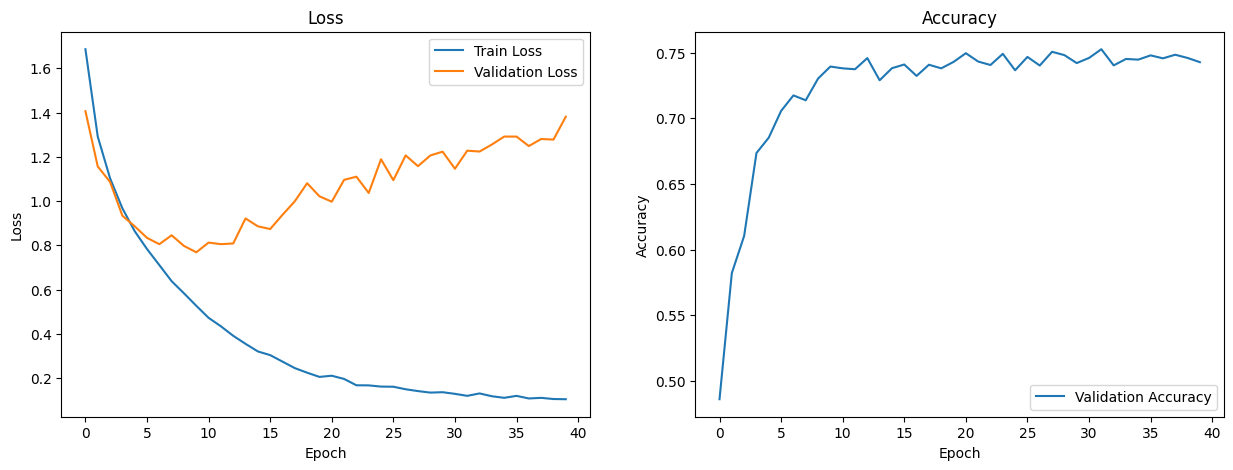

In [43]:
threelayer_history = history + threelayer_history # yukarıdaki for loop'unda three layer history train başlamıştı. Aslında yukarıdaki cellde train işlemine
# en baştan başlamak yerine devam ediliyor.
plot_history(threelayer_history)

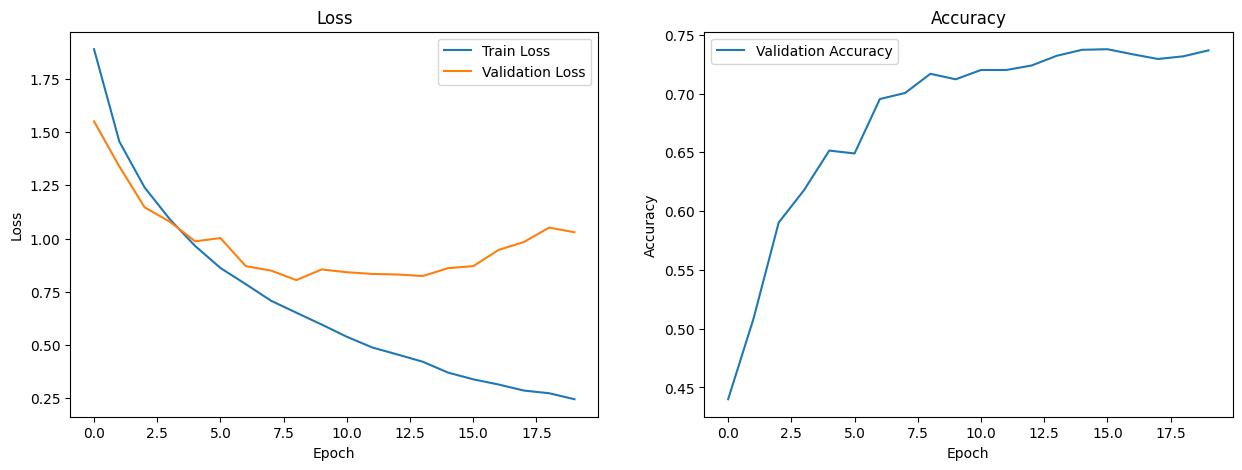

In [44]:
plot_history(fivelayer_history)

## Test aşaması

In [ ]:
# 3 katmanlı CNN modelinin grafiklerde 5 katmanlı modeli outperfom ettiği görülmektedir. Bu sebeple
# 3 katmanlı modeli 9 epoch yaparak, hem overfittingten kaçmak hem de potansiyel en yüksek accuracy değerini almak
# için önemlidir.

In [71]:
finalmodel = ThreeLayerCNN()

In [ ]:
to_device(finalmodel, device)

In [73]:
finalmodel_history = fit(epochs = 9,
                 model = finalmodel,
                 lr = 0.001,
                 train_loader = train_loader,
                 val_loader = val_loader,
                 opt_func = optim.Adam,
                 verbose = False)

In [74]:
test_dataset = ImageFolder(DATA_DIR+'/test', transform=ToTensor())

Label: 3


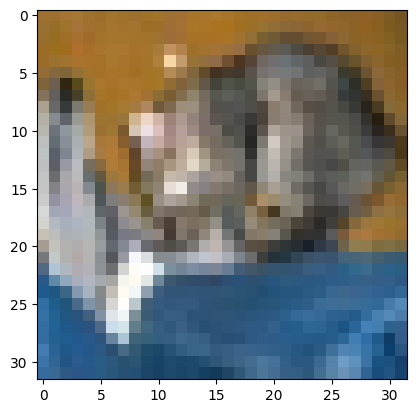

In [75]:
img, label = test_dataset[3000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', label)

In [76]:
img.unsqueeze(0).shape #testten alınacak labellar 1 batch olarak verilecek.

torch.Size([1, 3, 32, 32])

In [ ]:
finalmodel

In [79]:
test_data = to_device(img.unsqueeze(0), device)

In [99]:
tensor, preds = torch.max(finalmodel(test_data), dim= 1)

test_dataset.classes[preds[0].item()]

'cat'

In [136]:
def predict_it(img):
  # 1'lik mini batchi gpu'ya alıyoruz. çünkü model gpu'da
  test_data = to_device(img.unsqueeze(0), device)

  # modele veriyoruz.
  output = finalmodel(test_data)

  #prediction aliyoruz.
  tensor, preds = torch.max(finalmodel(test_data), dim= 1)

  return test_dataset.classes[preds[0].item()]


Label: cat Predicted: cat


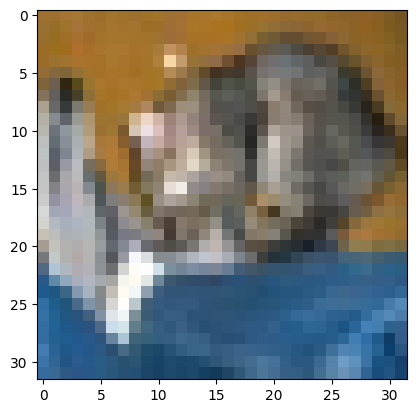

In [103]:
img, label = test_dataset[3000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_dataset.classes[label], 'Predicted:', predict_it(img)) # doğru sonuç alabiliyoruz.

In [109]:
test_loader = DataLoader(test_dataset, batch_size= 512)
test_loader = DeviceDataLoader(test_loader, device)

In [149]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [144]:
def predict_test_batch(img):
  # 1'lik mini batchi gpu'ya alıyoruz. çünkü model gpu'da
  test_data = to_device(img, device)

  # modele veriyoruz.
  output = finalmodel(test_data)

  #prediction aliyoruz.
  tensor, preds = torch.max(finalmodel(test_data), dim= 1)

  return preds


In [145]:
def get_confusion_matrix(finalmodel, test_loader):
  true_labels = []
  predicted_labels = []

  with torch.no_grad(): # ögrenme olmicak
    for images, labels in test_loader:

      predicted = predict_test_batch(images) # görsel

      true_labels.extend(labels.cpu().numpy())
      predicted_labels.extend(predicted.cpu().numpy())

  return confusion_matrix(true_labels, predicted_labels)

In [146]:
cm = get_confusion_matrix(finalmodel, test_loader)

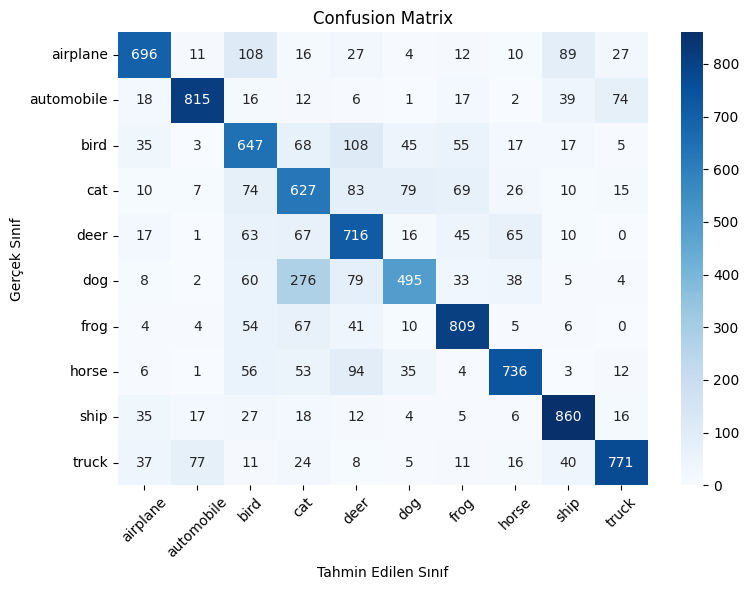

In [166]:
class_names = test_dataset.classes
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"ha": 'center', "va": 'center'})
plt.xticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(class_names))+0.5, labels=class_names, rotation=0)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [167]:
print(test_dataset.classes[3], test_dataset.classes[1]) # labellar doğru

cat automobile


In [151]:
results = evaluate(finalmodel, test_loader)

In [152]:
print("Test Acc:", round(results[1][1].item(), 4)) # .71 final acc

Test Acc: 0.7187
